In [266]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import squareform
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
import multiprocessing
import os
import numpy as np
import treeCl
from scipy.special import huber as huber_loss
from scipy.cluster import hierarchy
from sklearn.cluster import spectral_clustering
from sklearn.metrics.cluster import adjusted_mutual_info_score
import community
import networkx as nx
from math import log

def variation_of_information(X, Y):
    #https://gist.github.com/jwcarr/626cbc80e0006b526688
    n = float(sum([len(x) for x in X]))
    sigma = 0.0
    for x in X:
        p = len(x) / n
        for y in Y:
            q = len(y) / n
            r = len(set(x) & set(y)) / n
            if r > 0.0:
                sigma += r * (log(r / p, 2) + log(r / q, 2))
    return abs(sigma)

%matplotlib inline
%cd /work/clusterEvo/

/work/clusterEvo


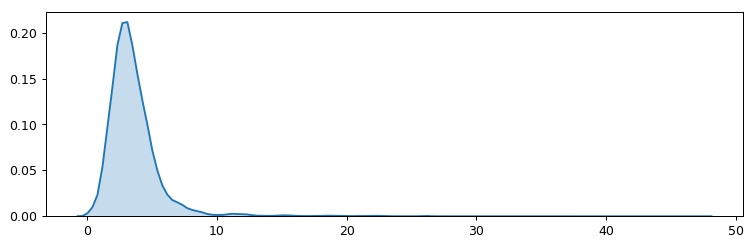

In [107]:
geodesic_df = pd.read_csv('geodesic_distances.csv', index_col=0)

fig, ax = plt.subplots(dpi=90, figsize=(10,3))
sns.kdeplot(squareform(geodesic_df.values), shade=True, ax=ax)

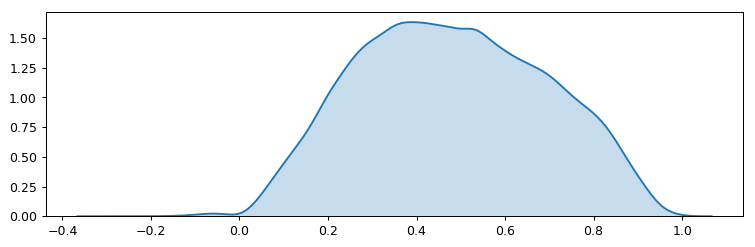

In [6]:
corr = pd.read_table('distance_matrices_correlations.tab',   index_col=0)
qval = pd.read_table('distance_matrices_corrected_pval.tab', index_col=0)

condensed_qval = squareform(qval.values, checks=False)
condensed_qval[pd.isnull(condensed_qval)] = 1
condensed_corr = squareform(corr.values, checks=False)[condensed_qval <= 0.05]

fig, ax = plt.subplots(dpi=90, figsize=(10,3))
sns.kdeplot(condensed_corr, shade=True, ax=ax)

In [51]:
#%%timeit  -n 20 -r 10
def run_regression((g1, g2)):
    df1 = pd.read_table('distance_matrices/%s/%s.mldist.tab' % (g1, g1), index_col=0)
    df2 = pd.read_table('distance_matrices/%s/%s.mldist.tab' % (g2, g2), index_col=0)

    intersection = df1.index.intersection(df2.index)
    df1 = df1.reindex(index=intersection, columns=intersection)
    df2 = df2.reindex(index=intersection, columns=intersection)

    if intersection.shape[0] < 10:
        return np.nan

    x = squareform(df1.values)
    y = squareform(df2.values)
    regress = LinearRegression(fit_intercept=False)
    try:
        regress.fit(x.reshape(-1, 1),
                  y)
    except ValueError:
        return np.nan
    return mean_squared_error(regress.predict(x.reshape(-1, 1)), y)

groups = os.listdir('distance_matrices/')
pairs  = list(combinations(groups, 2))
pool   = multiprocessing.Pool(processes=10)
mse    = pool.map(run_regression, pairs)
mse    = np.asarray(mse)
mse_df = pd.DataFrame(index=groups, columns=groups, data=squareform(mse))
mse_df.to_csv('linear_regression_mse.csv')

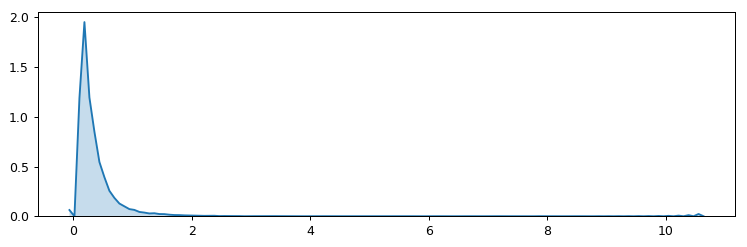

In [105]:
ols_df = pd.read_csv('linear_regression_mse.csv', index_col=0)
ols_condensed = squareform(ols_df.values, checks=False)
fig, ax = plt.subplots(dpi=90, figsize=(10,3))
sns.kdeplot(ols_condensed[pd.notnull(ols_condensed)], shade=True, ax=ax)

In [101]:
#%%timeit  -n 20 -r 10
def run_huber((g1, g2)):
    df1 = pd.read_table('distance_matrices/%s/%s.mldist.tab' % (g1, g1), index_col=0)
    df2 = pd.read_table('distance_matrices/%s/%s.mldist.tab' % (g2, g2), index_col=0)

    intersection = df1.index.intersection(df2.index)
    df1 = df1.reindex(index=intersection, columns=intersection)
    df2 = df2.reindex(index=intersection, columns=intersection)

    if intersection.shape[0] < 10:
        return np.nan

    x = squareform(df1.values)
    y = squareform(df2.values)
    huber = HuberRegressor(fit_intercept=False)
    try:
        huber.fit(x.reshape(-1, 1),
                  y)
    except ValueError:
        return np.nan
    residuals = huber.predict(x.reshape(-1, 1)) - y
    return huber_loss(huber.epsilon, residuals).mean()

groups = os.listdir('distance_matrices/')
pairs  = list(combinations(groups, 2))
pool   = multiprocessing.Pool(processes=10)
mse    = pool.map(run_huber, pairs)
mse    = np.asarray(mse)
mse_df = pd.DataFrame(index=groups, columns=groups, data=squareform(mse))
mse_df.to_csv('huber_regression_mse.csv')

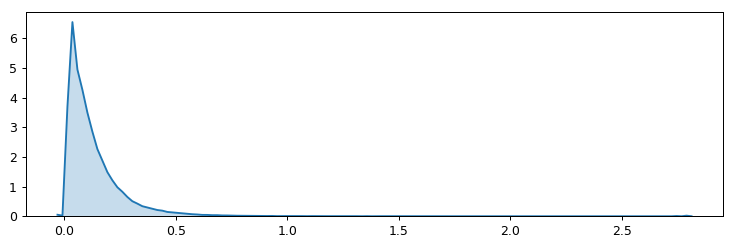

In [103]:
huber_df = pd.read_csv('huber_regression_mse.csv', index_col=0)
huber_condensed = squareform(huber_df.values, checks=False)
fig, ax  = plt.subplots(dpi=90, figsize=(10,3))
sns.kdeplot(huber_condensed[pd.notnull(huber_condensed)], shade=True, ax=ax)

In [35]:
collection = treeCl.Collection(input_dir='alignments/', file_format='fasta', trees_dir='trees/')

processes = treeCl.parutils.ProcesspoolJobHandler(10)  # with pure python code, it is better to use processpools to parallelise for speed
dm = collection.get_inter_tree_distances('rf', 
                                jobhandler=processes, 
                                batchsize=100)

rf_df = pd.DataFrame(index=dm.get_names(), columns=dm.get_names(), data=dm.values)
rf_df.to_csv('robinson_foulds.csv')

Loading files: 485 of 485 |###############| Elapsed Time: 0:00:17 Time: 0:00:17
Loading trees: 100% |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


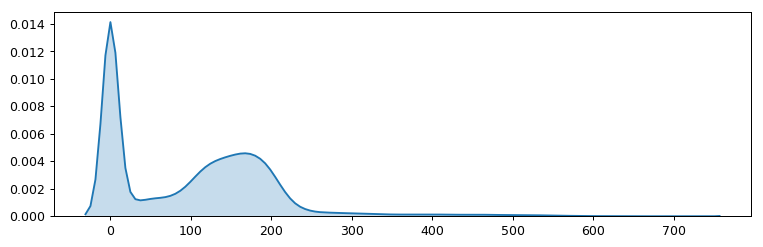

In [106]:
rf_df = pd.read_csv('robinson_foulds.csv', index_col=0)
rf_condensed = squareform(rf_df.values, checks=False)
fig, ax  = plt.subplots(dpi=90, figsize=(10,3))
sns.kdeplot(rf_condensed[pd.notnull(rf_condensed)], shade=True, ax=ax)

In [174]:
ols_df   = ols_df.reindex(index=geodesic_df.index, columns=geodesic_df.columns)
huber_df = huber_df.reindex(index=geodesic_df.index, columns=geodesic_df.columns)
rf_df    = rf_df.reindex(index=geodesic_df.index, columns=geodesic_df.columns)

geo_condensed = squareform(geodesic_df.values, checks=False)
rf_condensed = squareform(rf_df.values, checks=False)
huber_condensed = squareform(huber_df.values, checks=False)
ols_condensed = squareform(ols_df.values, checks=False)

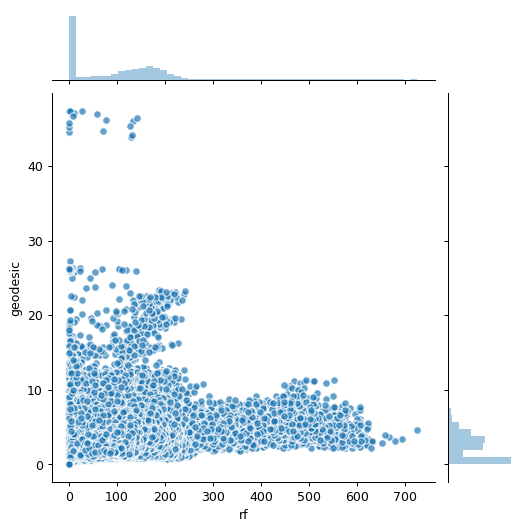

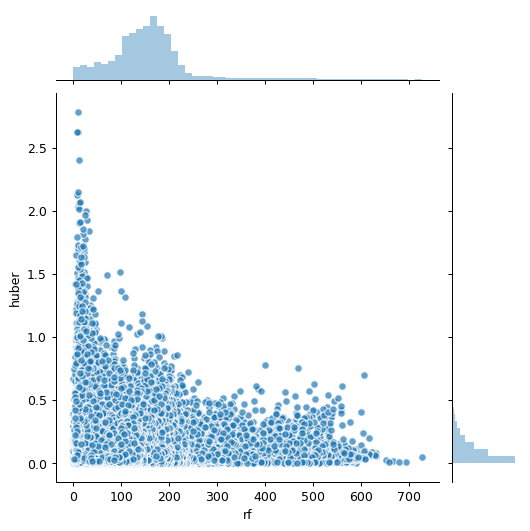

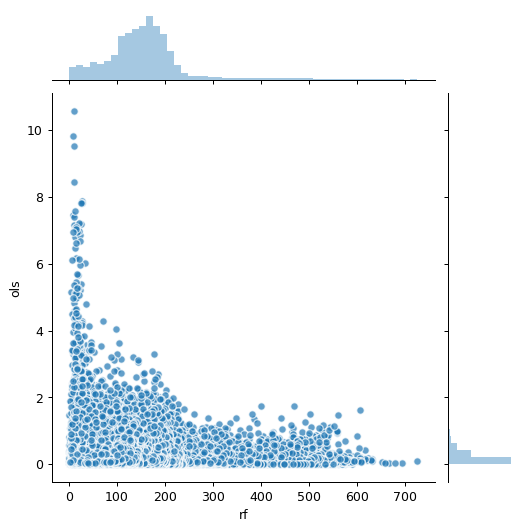

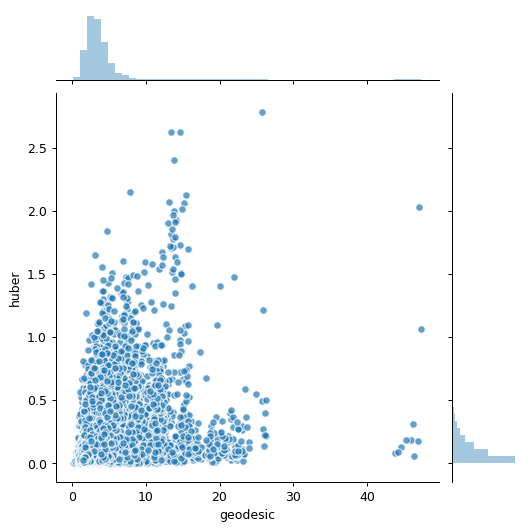

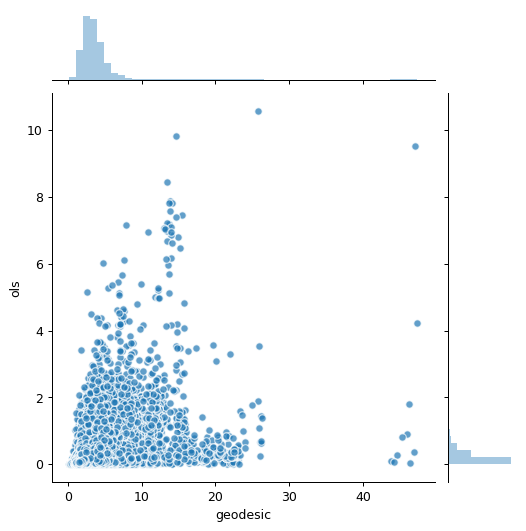

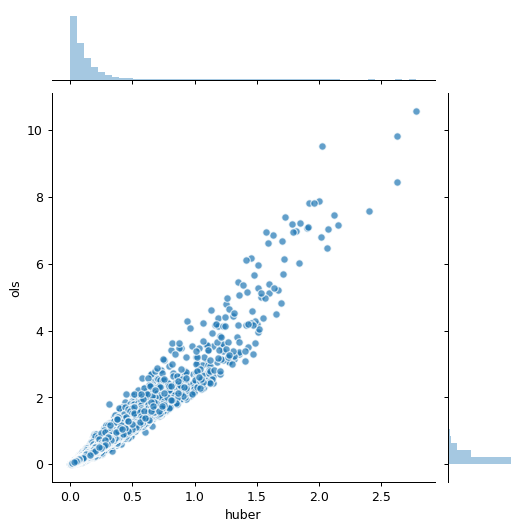

In [115]:
matrices = [('rf', rf_condensed), ('geodesic', geo_condensed),
            ('huber', huber_condensed), ('ols', ols_condensed)]
for (name1, condensed1), (name2, condensed2) in combinations(matrices, 2):
    x = condensed1[pd.notnull(condensed1) & pd.notnull(condensed2)]
    y = condensed2[pd.notnull(condensed1) & pd.notnull(condensed2)]

    plot = sns.jointplot(x=pd.Series(data=x, name=name1), y=pd.Series(data=y, name=name2),
                         joint_kws=dict(alpha=0.7, edgecolor='w'))
    plot.fig.set_dpi(90)

In [202]:
geo_dissimilarity = 1 - (geo_condensed.copy() / geo_condensed.max())
ols_dissimilarity = 1 - (ols_condensed.copy() / ols_condensed[pd.notnull(ols_condensed)].max())
rf_dissimilarity  = 1 - (rf_condensed.copy()  / rf_condensed.max())

In [207]:
pairs = list(combinations(geodesic_df.index, 2))

geo_graph = nx.Graph()
geo_graph.add_weighted_edges_from([(u, v, w) for (u, v), w, w1 in zip(pairs, geo_dissimilarity, ols_dissimilarity)
                                  if pd.notnull(w1)])
ols_graph = nx.Graph()
ols_graph.add_weighted_edges_from([(u, v, w) for (u, v), w in zip(pairs, ols_dissimilarity) if pd.notnull(w)])
rf_graph  = nx.Graph()
rf_graph.add_weighted_edges_from([(u, v, w) for (u, v), w, w1 in zip(pairs, rf_dissimilarity, ols_dissimilarity)
                                 if pd.notnull(w1)])

geo_partition = community.best_partition(geo_graph, random_state=12345)
ols_partition = community.best_partition(ols_graph, random_state=12345)
rf_partition  = community.best_partition(rf_graph,  random_state=12345)

clusters = {'geo':{}, 'ols':{}, 'rf':{}}
for i, j in geo_partition.items():
    if not j in clusters['geo']:
        clusters['geo'][j] = []
    clusters['geo'][j].append(i)

for i, j in ols_partition.items():
    if not j in clusters['ols']:
        clusters['ols'][j] = []
    clusters['ols'][j].append(i)

for i, j in rf_partition.items():
    if not j in clusters['rf']:
        clusters['rf'][j] = []
    clusters['rf'][j].append(i)

In [220]:
for method1, method2 in combinations(clusters.keys(), 2):
    print method1, method2
    print variation_of_information(clusters[method1].values(), clusters[method2].values())

rf ols
0.939138259454
rf geo
0.885261886359
ols geo
0.297329035925


In [279]:
num_clusters = 10
geo_spectral = spectral_clustering(nx.to_scipy_sparse_matrix(geo_graph), n_clusters=num_clusters, random_state=12345)
ols_spectral = spectral_clustering(nx.to_scipy_sparse_matrix(ols_graph), n_clusters=num_clusters, random_state=12345)
rf_spectral  = spectral_clustering(nx.to_scipy_sparse_matrix(rf_graph),  n_clusters=num_clusters, random_state=12345)

spectral_clusters = {'geo':{}, 'ols':{}, 'rf':{}}
for j, i in zip(geo_spectral, geodesic_df.columns):
    if not j in spectral_clusters['geo']:
        spectral_clusters['geo'][j] = []
    spectral_clusters['geo'][j].append(i)

for j, i in zip(ols_spectral, ols_df.columns):
    if not j in spectral_clusters['ols']:
        spectral_clusters['ols'][j] = []
    spectral_clusters['ols'][j].append(i)

for j, i in zip(rf_spectral, rf_df.columns):
    if not j in spectral_clusters['rf']:
        spectral_clusters['rf'][j] = []
    spectral_clusters['rf'][j].append(i)

In [275]:
for method1, method2 in combinations(spectral_clusters.keys(), 2):
    print '%s %s: %f' % (method1, method2, 
                         variation_of_information(spectral_clusters[method1].values(), 
                                                  spectral_clusters[method2].values()))
    

rf ols: 1.122431
rf geo: 0.800634
ols geo: 1.012147


In [280]:
print 'geodesic ols: %f' % adjusted_mutual_info_score(geo_spectral, ols_spectral)
print 'geodesic rf:  %f' % adjusted_mutual_info_score(geo_spectral, rf_spectral)
print 'ols rf:       %f' % adjusted_mutual_info_score(rf_spectral, ols_spectral)

geodesic ols: 0.820413
geodesic rf:  0.850634
ols rf:       0.794050
